# Análise Estatística de Dados e Informações
**PPCA/UNB**

---

**Prova - Questão 01**  
**Professor**: João Gabriel de Moraes Sousa  
**Aluna**: Andreia Queiroz Correia Dummar  
**Matrícula**: 241134680  
**Data da Entrega**: 09/02/2025  
**Github**: https://github.com/aqcorreia/AEDI/tree/main/Prova

---

**Aplicação**: Regressão Linear

**Dados**: House Sales in King County, USA (https://www.kaggle.com/datasets/harlfoxem/housesalesprediction)

---

O dataset **House Sales in King County, USA** contém informações sobre vendas de imóveis na região de King County, Washington, EUA. Ele pode ser utilizado para análise do mercado imobiliário, previsão de preços e avaliação de tendências.

Contém as seguintes colunas:

| Coluna           | Descrição |
|-----------------|-----------|
| **id**          | Identificador único do imóvel. |
| **date**        | Data da venda do imóvel. |
| **price**       | Preço de venda do imóvel em dólares. |
| **bedrooms**    | Número de quartos no imóvel. |
| **bathrooms**   | Número de banheiros no imóvel (inclui frações para banheiros parciais). |
| **sqft_living** | Área útil do imóvel em pés quadrados. |
| **sqft_lot**    | Área total do terreno do imóvel em pés quadrados. |
| **floors**      | Número de andares do imóvel. |
| **waterfront**  | Indica se o imóvel tem vista para a água (1 = Sim, 0 = Não). |
| **view**        | Índice de qualidade da vista do imóvel (quanto maior, melhor a vista). |
| **condition**   | Estado geral do imóvel (avaliação qualitativa). |
| **grade**       | Classificação da construção e design do imóvel (avaliação qualitativa). |
| **sqft_above**  | Área construída acima do solo em pés quadrados. |
| **sqft_basement** | Área do porão em pés quadrados. |
| **yr_built**    | Ano de construção do imóvel. |
| **yr_renovated** | Ano da última reforma do imóvel (0 se nunca foi reformado). |
| **zipcode**     | Código postal (CEP) da localização do imóvel. |
| **lat**        | Latitude da localização do imóvel. |
| **long**       | Longitude da localização do imóvel. |
| **sqft_living15** | Média da área útil dos imóveis vizinhos em pés quadrados. |
| **sqft_lot15**  | Média da área total dos terrenos vizinhos em pés quadrados. |

---


## 1) Bibliotecas

In [1]:
# Bibliotecas para manipulação de dados
import pandas as pd
import numpy as np

# Bibliotecas para visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Biblioteca para manipulação de datas
from datetime import datetime

# Bibliotecas para estatística
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Bibliotecas para normalização e padronização
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Biblioteca para divisão de dados
from sklearn.model_selection import train_test_split

# Bibliotecas para criação de modelos
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Bibliotecas para avaliação de modelos
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Bibliotecas auxiliares
import time
from itertools import combinations

## 2) Funções

In [2]:
def verificar_valores_faltantes(df):
    """
    Função para verificar valores faltantes em um DataFrame.

    Parâmetros:
        df (pd.DataFrame): O DataFrame a ser analisado.

    Retorno:
        pd.DataFrame: DataFrame com as colunas, a quantidade de valores faltantes e o percentual correspondente.
    """
    # Contar valores faltantes por coluna
    valores_faltantes = df.isnull().sum()
    
    # Filtrar apenas colunas com valores faltantes (ignorar valores zero)
    valores_faltantes = valores_faltantes[valores_faltantes > 0]
    
    # Calcular o percentual de valores faltantes
    percentual_faltante = (valores_faltantes / len(df)) * 100
    
    # Criar DataFrame com as informações
    resultado = pd.DataFrame({
        'Coluna': valores_faltantes.index,
        'Valores Faltantes': valores_faltantes.values,
        'Percentual Faltante (%)': percentual_faltante.values
    })
    
    # Ordenar pelo número de valores faltantes
    resultado = resultado.sort_values(by='Valores Faltantes', ascending=False).reset_index(drop=True)
    
    return resultado

In [3]:
def criar_dataframe_normalizado(df, colunas_independentes, colunas_dependentes):
    """
    Normaliza as colunas independentes de um DataFrame, mantendo as colunas dependentes na escala original.

    Parâmetros:
    df (pd.DataFrame): DataFrame original
    colunas_independentes (list): Lista das colunas que serão normalizadas
    colunas_dependentes (list): Lista das colunas dependentes (não serão normalizadas)

    Retorno:
    pd.DataFrame: DataFrame com colunas independentes normalizadas e colunas dependentes originais.
    """
    # Separando X (variáveis independentes) e Y (variáveis dependentes)
    X = df[colunas_independentes]
    Y = df[colunas_dependentes]  # Agora aceita múltiplas colunas dependentes

    # Normalizando X com StandardScaler
    scaler = StandardScaler()
    X_normalizado = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    # Concatenando X normalizado com Y original
    df_normalizado = pd.concat([X_normalizado, Y], axis=1)

    return df_normalizado


In [4]:
def calcular_vif(df):
    """
    Calcula o VIF (Variance Inflation Factor) para todas as variáveis independentes em um DataFrame.

    Parâmetros:
    - df (DataFrame): DataFrame apenas com variáveis numéricas.

    Retorna:
    - DataFrame com as variáveis e seus respectivos VIFs.
    """
    # Remover colunas constantes
    df = df.loc[:, df.nunique() > 1]

    # Adiciona uma constante para a regressão
    df = df.assign(constante=1)

    # Calcula o VIF para cada variável
    vif_data = pd.DataFrame()
    vif_data["Variável"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    # Remove a constante antes de retornar
    return vif_data[vif_data["Variável"] != "constante"]


In [5]:
def calcular_covariancia(df, colunas_dependentes):
    """
    Calcula a matriz de covariância excluindo as colunas dependentes.

    Parâmetros:
    df (pd.DataFrame): DataFrame com os dados numéricos.
    colunas_dependentes (list): Lista das colunas dependentes a serem excluídas.

    Retorno:
    Exibe a matriz de covariância no console e gera um heatmap.
    """
    # Remover colunas dependentes para focar nas independentes
    X_normalizado = df.drop(columns=colunas_dependentes)

    # Calcular a matriz de covariância
    cov_matrix = X_normalizado.cov()

    # Visualizar com um heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cov_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Matriz de Covariância (Normalizada)")
    plt.show()

    return cov_matrix


In [6]:
def criar_grafico_dispersao(df, coluna_x, coluna_y, cor="blue", tamanho_ponto=50, incluir_regressao=True):
    """
    Gera um gráfico de dispersão a partir de um DataFrame, com opção de incluir uma reta de regressão linear.

    Parâmetros:
    - df (DataFrame): DataFrame contendo os dados.
    - coluna_x (str): Nome da coluna para o eixo X.
    - coluna_y (str): Nome da coluna para o eixo Y.
    - cor (str, opcional): Cor dos pontos. Padrão é "blue".
    - tamanho_ponto (int, opcional): Tamanho dos pontos no gráfico. Padrão é 50.
    - incluir_regressao (bool, opcional): Se True, adiciona uma reta de regressão linear.

    Retorna:
    - Um gráfico de dispersão exibido na tela.
    """

    titulo = f"Gráfico de Dispersão - {coluna_x} X {coluna_y}"
    if coluna_x not in df.columns or coluna_y not in df.columns:
        raise ValueError(f"As colunas {coluna_x} e/ou {coluna_y} não estão no DataFrame.")

    plt.figure(figsize=(12, 6))

    # Criando o gráfico de dispersão com Seaborn
    sns.scatterplot(x=df[coluna_x], y=df[coluna_y], color=cor, alpha=0.6, s=tamanho_ponto)

    # Adicionando a reta de regressão, se solicitado
    if incluir_regressao:
        sns.regplot(x=df[coluna_x], y=df[coluna_y], scatter=False, color="red", line_kws={"linewidth": 2})

    plt.title(titulo, fontsize=14)
    plt.xlabel(coluna_x, fontsize=12)
    plt.ylabel(coluna_y, fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()


In [7]:
def criar_grafico_boxplot(df, coluna_x, coluna_y, cor="blue"):
    """
    Gera um gráfico boxplot a partir de um DataFrame.

    Parâmetros:
    - df (DataFrame): DataFrame contendo os dados.
    - coluna_x (str): Nome da coluna para o eixo X (variável categórica).
    - coluna_y (str): Nome da coluna para o eixo Y (variável numérica).
    - cor (str, opcional): Cor dos boxplots. Padrão é "blue".

    Retorna:
    - Um gráfico boxplot exibido na tela.
    """

    titulo = f"Gráfico de Boxplot - {coluna_x} X {coluna_y}"
    if coluna_x not in df.columns or coluna_y not in df.columns:
        raise ValueError(f"As colunas {coluna_x} e/ou {coluna_y} não estão no DataFrame.")

    plt.figure(figsize=(8 * 1.6, 6))
    sns.boxplot(data=df, x=coluna_x, y=coluna_y, color=cor)
    plt.title(titulo, fontsize=14)
    plt.xlabel(coluna_x, fontsize=12)
    plt.ylabel(coluna_y, fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()


In [8]:
def criar_histograma(df, v_coluna, bins=30):
    """
    Cria um histograma para visualizar a distribuição da variável contínua.
    
    Parâmetros:
    - df: DataFrame contendo os dados
    - v_coluna: Nome da variável a ser plotada
    - bins: Número de bins para o histograma (padrão: 30)
    """
    plt.figure(figsize=(8,5))
    sns.histplot(df[v_coluna], bins=bins, kde=True, color='blue')
    plt.xlabel(v_coluna)
    plt.ylabel("Frequência")
    plt.title(f"Histograma da variável {v_coluna}")
    plt.show()

In [9]:
def realizar_anova(df, variavel_quantitativa, variavel_categorica):
    """
    Realiza o teste ANOVA em um DataFrame.

    Parâmetros:
    - df (DataFrame): O DataFrame contendo os dados.
    - variavel_quantitativa (str): Nome da coluna com a variável quantitativa (dependente).
    - variavel_categorica (str): Nome da coluna com a variável categórica (independente).

    Retorna:
    - Um dicionário com os resultados do teste ANOVA (F-statistic e p-value).
    
    Exemplo:
    realizar_anova(df, "altura", "grupo")
    """
    # Verifica se as colunas existem no DataFrame
    if variavel_quantitativa not in df.columns or variavel_categorica not in df.columns:
        raise ValueError(f"As colunas {variavel_quantitativa} e/ou {variavel_categorica} não estão no DataFrame.")

    # Agrupa os dados por categorias
    grupos = [grupo[variavel_quantitativa].dropna() for nome, grupo in df.groupby(variavel_categorica)]

    # Realiza o teste ANOVA
    f_statistic, p_value = stats.f_oneway(*grupos)

    # Retorna os resultados
    return {
        "F-statistic": f_statistic,
        "p-value": p_value
    }

In [10]:
def analise_variavel_categorica(df, v_coluna):
    """
    Realiza a análise de uma variável categórica em relação à variável alvo 'price'.

    Parâmetros:
    - df: DataFrame contendo os dados
    - v_coluna: Nome da variável categórica a ser analisada
    """

    print(df[[v_coluna]].describe())
    
    print("______________________________________________________________________________________________")

    # Criando os gráficos lado a lado
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # Define layout com 1 linha e 2 colunas

    # Gráfico de dispersão
    sns.scatterplot(x=df[v_coluna], y=df['price'], ax=axes[0])
    axes[0].set_title(f"Dispersão de {v_coluna} vs Price")
    axes[0].set_xlabel(v_coluna)
    axes[0].set_ylabel("Price")
    axes[0].tick_params(axis='x', rotation=45)

    # Boxplot
    sns.boxplot(x=df[v_coluna], y=df['price'], ax=axes[1])
    axes[1].set_title(f"Boxplot de {v_coluna} vs Price")
    axes[1].set_xlabel(v_coluna)
    axes[1].set_ylabel("Price")
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()  # Ajusta o espaçamento entre os gráficos
    plt.show()

    print("______________________________________________________________________________________________")

    # Correlação de Pearson
    correlacao, p_valor = stats.pearsonr(df[v_coluna].astype('category').cat.codes, df["price"])
    print(f"Correlação de Pearson: {correlacao:.3f} (p-valor: {p_valor:.3f})")
    
    print("______________________________________________________________________________________________")

    # Exibição das contagens
    contagens = df[v_coluna].value_counts()
    print(contagens)
    
    print("______________________________________________________________________________________________")

    # Teste ANOVA
    resultado = stats.f_oneway(*[df.loc[df[v_coluna] == categoria, "price"] for categoria in df[v_coluna].unique()])
    print(f"Resultado ANOVA: F={resultado.statistic:.3f}, p={resultado.pvalue:.3f}")
    
    print("______________________________________________________________________________________________")


In [11]:
def analise_variavel_continua(df, v_coluna):
    """
    Realiza a análise de uma variável contínua em relação à variável alvo 'price'.

    Parâmetros:
    - df: DataFrame contendo os dados
    - v_coluna: Nome da variável contínua a ser analisada
    """

    print(df[[v_coluna]].describe())
    
    print("______________________________________________________________________________________________")

    # Criando os gráficos lado a lado
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # Define layout com 1 linha e 2 colunas

    # Gráfico de dispersão
    sns.scatterplot(x=df[v_coluna], y=df['price'], ax=axes[0])
    axes[0].set_title(f"Dispersão de {v_coluna} vs Price")
    axes[0].set_xlabel(v_coluna)
    axes[0].set_ylabel("Price")
    axes[0].tick_params(axis='x', rotation=45)

    # Histograma
    sns.histplot(df[v_coluna], kde=True, ax=axes[1])
    axes[1].set_title(f"Histograma de {v_coluna}")
    axes[1].set_xlabel(v_coluna)
    axes[1].set_ylabel("Frequência")

    plt.tight_layout()  # Ajusta o espaçamento entre os gráficos
    plt.show()

    print("______________________________________________________________________________________________")

    # Correlação de Pearson
    correlacao, p_valor = stats.pearsonr(df[v_coluna], df["price"])
    print(f"Correlação de Pearson: {correlacao:.3f} (p-valor: {p_valor:.3f})")
    
    print("______________________________________________________________________________________________")
    
    # Outros cálculos podem ser adicionados aqui, como análise adicional
    # Se necessário, adicione outras análises ou gráficos.
    print("______________________________________________________________________________________________")


In [12]:
def remove_outliers(df, coluna="price"):
    """
    Calcula o limite superior para detecção de outliers usando o método IQR.

    Parâmetros:
    - df: DataFrame contendo os dados.
    - coluna: Nome da coluna a ser analisada.

    Retorna:
    - O valor limite superior recomendado.
    """
    Q1 = np.percentile(df[coluna], 25)  # 1º quartil (25%)
    Q3 = np.percentile(df[coluna], 75)  # 3º quartil (75%)
    IQR = Q3 - Q1  # Intervalo Interquartil

    limite_superior = Q3 + 1.5 * IQR  # Definição de outlier superior

    return df[df['price'] <= limite_superior]

In [13]:
def executar_regressao_linear(df, variaveis_independentes, variavel_dependente):
    """
    Executa uma regressão linear utilizando variáveis independentes já normalizadas.

    Parâmetros:
    - df: DataFrame contendo os dados
    - variaveis_independentes: Lista com os nomes das colunas independentes (já normalizadas)
    - variavel_dependente: Nome da coluna dependente

    Retorna:
    - Modelo treinado, métricas de desempenho e DataFrame com coeficientes
    """

    # Separando variáveis independentes (X) e dependente (y)
    X = df[variaveis_independentes].copy()
    y = df[variavel_dependente].copy()

    # Verificação de multicolinearidade (VIF)
    vif_data = pd.DataFrame()
    vif_data["Variável"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    print("\nVerificação de Multicolinearidade (VIF)")
    print(vif_data)

    # Dividindo os dados em treino e teste (80% treino, 20% teste)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Criando e treinando o modelo de regressão linear
    modelo = LinearRegression()
    modelo.fit(X_train, y_train)

    # Fazendo previsões
    y_pred = modelo.predict(X_test)

    # Calculando métricas de desempenho
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Exibir métricas
    print("\nIndicadores do Modelo de Regressão Linear:")
    print(f"🔹 Mean Absolute Error (MAE): {mae:.2f}")
    print(f"🔹 Mean Squared Error (MSE): {mse:.2f}")
    print(f"🔹 Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"🔹 R² Score: {r2:.4f}")
    
    print("______________________________________________________________________________________________")

    # Exibir coeficientes do modelo
    coeficientes = pd.DataFrame({
        "Variável": variaveis_independentes,
        "Coeficiente": modelo.coef_
    }).sort_values(by="Coeficiente", ascending=False)

    intercepto = modelo.intercept_

    print("\nCoeficientes do Modelo:")
    print(coeficientes)
    print(f"\nInterceptação (constante): {intercepto:.4f}")
    
    print("______________________________________________________________________________________________")

    # Gráfico de análise de resíduos
    plt.figure(figsize=(8, 5))
    sns.residplot(x=y_pred, y=y_test - y_pred, lowess=True, line_kws={"color": "red"})
    plt.axhline(0, color='black', linestyle='--')  # Linha horizontal para facilitar a análise
    plt.xlabel("Valores Preditos")
    plt.ylabel("Resíduos")
    plt.title("Análise de Resíduos - Verificação da Linearidade")
    plt.show()
    
    return modelo, coeficientes, intercepto


In [14]:
def evaluate_regression(df, independent_cols, dependent_cols, test_size=0.2, random_state=42):
    """
    Avalia múltiplas combinações de variáveis independentes para prever as variáveis dependentes
    utilizando regressão linear, separando os dados em treino e teste.

    Parâmetros:
    - df: DataFrame contendo os dados
    - independent_cols: Lista com os nomes das colunas independentes
    - dependent_cols: Lista das colunas dependentes
    - test_size: Proporção dos dados reservada para teste (padrão: 0.2, ou seja, 20%)
    - random_state: Semente para reprodutibilidade dos resultados (padrão: 42)

    Retorna:
    - DataFrame com os resultados de todas as combinações testadas
    - DataFrame com os melhores modelos para cada variável dependente
    """

    start_time = time.time()  # Inicia a contagem do tempo
    results = []
    total_combinations = sum([len(list(combinations(independent_cols, i))) for i in range(3, len(independent_cols) + 1)]) * len(dependent_cols)
    execution_count = 0  # Contador de execuções

    print(f"🔹 Total de execuções esperadas: {total_combinations}\n")

    for dependent_col in dependent_cols:
        for i in range(3, len(independent_cols) + 1):  # Testa combinações a partir de 3 variáveis
            for combo in combinations(independent_cols, i):

                # Separando as variáveis X e y
                X = df[list(combo)]
                y = df[dependent_col]

                # Dividindo os dados em treino e teste
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

                # Criando e treinando o modelo
                model = LinearRegression()
                model.fit(X_train, y_train)

                # Fazendo previsões nos dados de teste
                y_pred = model.predict(X_test)

                # Calculando métricas de desempenho
                mae = mean_absolute_error(y_test, y_pred)
                mse = mean_squared_error(y_test, y_pred)
                rmse = np.sqrt(mse)
                r2 = r2_score(y_test, y_pred)

                results.append({
                    'Variável Dependente': dependent_col,
                    'Variáveis Independentes': combo,
                    'MAE': mae,
                    'MSE': mse,
                    'RMSE': rmse,
                    'R² Score': r2,
                    'Coeficientes': dict(zip(combo, model.coef_))
                })

                execution_count += 1
                if execution_count % 5000 == 0 or execution_count == total_combinations:
                    elapsed_time = time.time() - start_time
                    print(f"✅ Execuções concluídas: {execution_count}/{total_combinations} | Tempo decorrido: {elapsed_time:.2f} segundos")

    df_results = pd.DataFrame(results)

    # Selecionar o melhor modelo para cada variável dependente com base no menor RMSE
    best_models = df_results.loc[df_results.groupby('Variável Dependente')['RMSE'].idxmin()]

    total_time = time.time() - start_time
    print(f"\n🚀 Processo finalizado! Tempo total: {total_time:.2f} segundos")

    return df_results, best_models


## 3) Leitura do arquivo

In [15]:
diretorio = './dados'

house_sales_data = pd.read_csv(f'{diretorio}/kc_house_data.csv', delimiter=',')

house_sales_data.shape

(21613, 21)

## 4) Análise descritiva

### 4.1) Análise geral

In [16]:
house_sales_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [17]:
house_sales_data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [18]:
# Criar um novo DataFrame sem a coluna 'date'
house_sales_data_01 = house_sales_data.drop(columns=['date'])
house_sales_data_01 = house_sales_data_01.drop(columns=['id'])

house_sales_data_01.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [19]:
house_sales_data_01.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


### 4.2) Verificar valores faltantes

In [20]:
result = verificar_valores_faltantes(house_sales_data_01)

if result.empty:
    print("Não há valores faltantes")
else:
    print(result.head(100))

Não há valores faltantes


### 4.3) Normalizar os dados

In [21]:
# Cria a coluna log_price
house_sales_data_01['price'] = house_sales_data_01['price'].replace(0, 1)
house_sales_data_01.loc[:, 'log_price'] = np.log(house_sales_data_01['price'])

colunas_independentes = ['bedrooms', 'bathrooms', 'sqft_living',
                         'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
                         'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
                         'lat', 'long', 'sqft_living15', 'sqft_lot15']

colunas_dependentes = ['price', 'log_price']  # Lista com múltiplas colunas dependentes

# Criando o DataFrame normalizado
house_sales_data_01_normalizado = criar_dataframe_normalizado(house_sales_data_01, colunas_independentes, colunas_dependentes)

# Visualizando as primeiras linhas
house_sales_data_01_normalizado.head()


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,log_price
0,-0.398737,-1.447464,-0.979835,-0.228321,-0.915427,-0.087173,-0.305759,-0.629187,-0.558836,-0.734708,-0.658681,-0.544898,-0.210128,1.870152,-0.352572,-0.306079,-0.943355,-0.260715,221900.0,12.309982
1,-0.398737,0.175607,0.533634,-0.189885,0.936506,-0.087173,-0.305759,-0.629187,-0.558836,0.460841,0.245141,-0.681079,4.746678,0.879568,1.161568,-0.746341,-0.432686,-0.187868,538000.0,13.195614
2,-1.473959,-1.447464,-1.426254,-0.123298,-0.915427,-0.087173,-0.305759,-0.629187,-1.409587,-1.229834,-0.658681,-1.293892,-0.210128,-0.933388,1.283537,-0.135655,1.070140,-0.172375,180000.0,12.100712
3,0.676485,1.149449,-0.130550,-0.244014,-0.915427,-0.087173,-0.305759,2.444294,-0.558836,-0.891699,1.397515,-0.204446,-0.210128,1.085160,-0.283288,-1.271816,-0.914174,-0.284522,604000.0,13.311329
4,-0.398737,-0.149007,-0.435422,-0.169653,-0.915427,-0.087173,-0.305759,-0.629187,0.291916,-0.130895,-0.658681,0.544548,-0.210128,-0.073636,0.409550,1.199335,-0.272190,-0.192849,510000.0,13.142166


### 4.4) Calcular o VIF (Variance Inflation Factor) e gerar a matriz de covariância

O Variance Inflation Factor (VIF) é uma métrica usada para identificar multicolinearidade entre variáveis independentes em um modelo de regressão. Ele mede o quanto a variância de um coeficiente de regressão aumenta devido à correlação entre as variáveis. Um **VIF próximo de 1 indica baixa correlação**, enquanto **valores acima de 5 ou 10 sugerem multicolinearidade significativa**, podendo prejudicar a interpretação dos coeficientes do modelo.

In [22]:
calcular_vif(house_sales_data_01_normalizado)

C:\Users\aqcor\anaconda3\envs\PPCA_AEDI\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Variável,VIF
0,bedrooms,1.687726
1,bathrooms,3.395691
2,sqft_living,inf
3,sqft_lot,2.109747
4,floors,2.053095
5,waterfront,1.269988
6,view,1.479799
7,condition,1.276641
8,grade,3.971489
9,sqft_above,inf


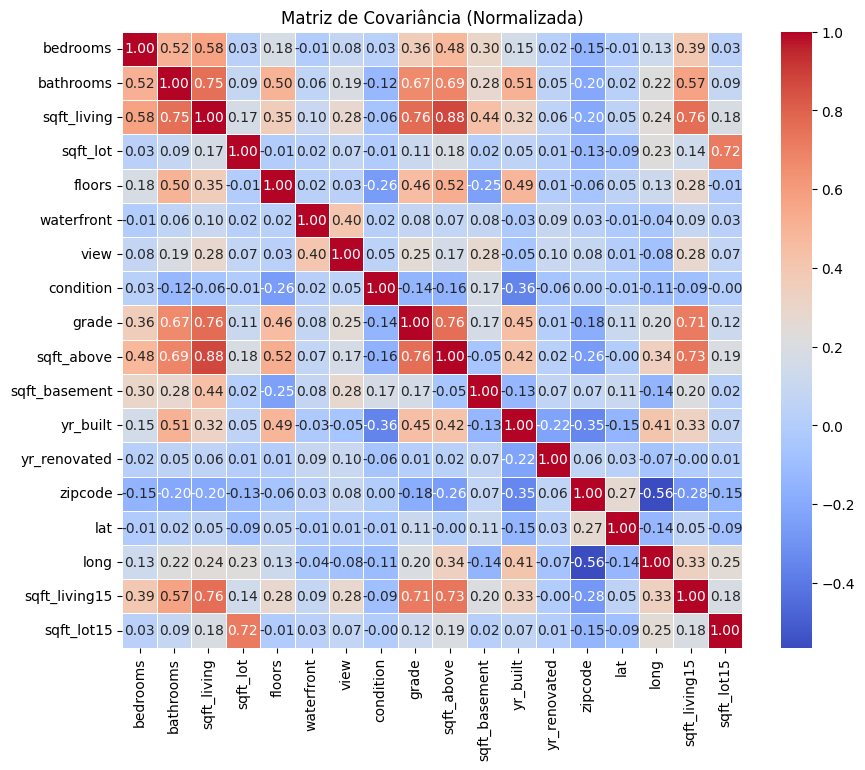

In [23]:
colunas_dependentes = ['price', 'log_price']

# Executando a função
cov_matrix = calcular_covariancia(house_sales_data_01_normalizado, colunas_dependentes)

---

#### Análise do Variance Inflation Factor (VIF)

A análise da **multicolinearidade (VIF)** revelou que `sqft_living`, `sqft_above` e `sqft_basement` possuem **valores infinitos**, indicando **multicolinearidade severa**. Variáveis como `bathrooms`, `grade` e `sqft_living15` apresentam **VIF moderado** (>3), sugerindo correlação consideráve. A **matriz de covariância** mostrou que `sqft_living` tem forte correlação com `grade` (0.76) e `sqft_above` (0.76), indicando que casas maiores tendem a ter melhor classificação. Além disso, `sqft_lot` e `sqft_lot15` também estão altamente correlacionados (0.72). Em relação ao preço (`price`), as variáveis mais influentes são `sqft_living`, `grade` e `bathrooms`, enquanto `zipcode`, `yr_renovated`, `lat` e `long` demonstram baixa correlação. 

Serão avaliadas para o modelo as variáveis: `sqft_living`, `bathrooms`, `yr_built`, `zipcode`, `yr_renovated` e `view`.

---

### 4.5) Análise das colunas

#### 4.4.1) Variável `sqft_living`

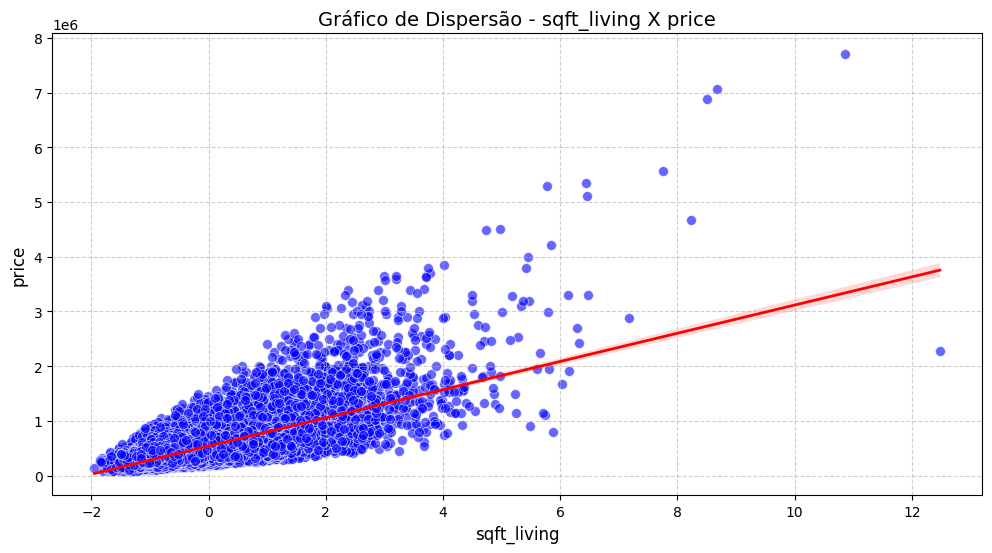

In [24]:
criar_grafico_dispersao(house_sales_data_01_normalizado, 'sqft_living', 'price', cor="blue", tamanho_ponto=50)

In [25]:
# Criar DataFrame filtrado
house_sales_data_01_normalizado_sem_outliers = remove_outliers(house_sales_data_01_normalizado, coluna="price")

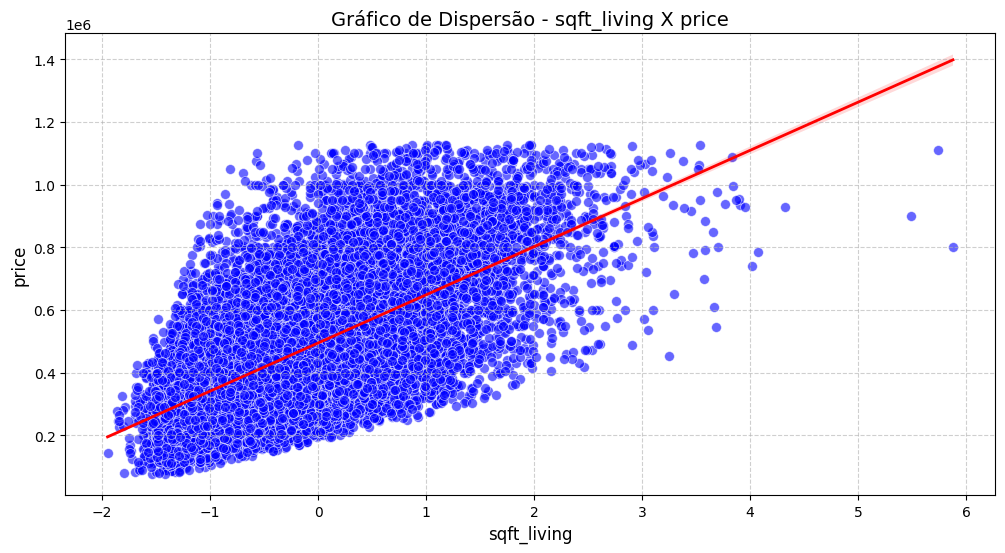

In [26]:
criar_grafico_dispersao(house_sales_data_01_normalizado_sem_outliers, 'sqft_living', 'price', cor="blue", tamanho_ponto=50)

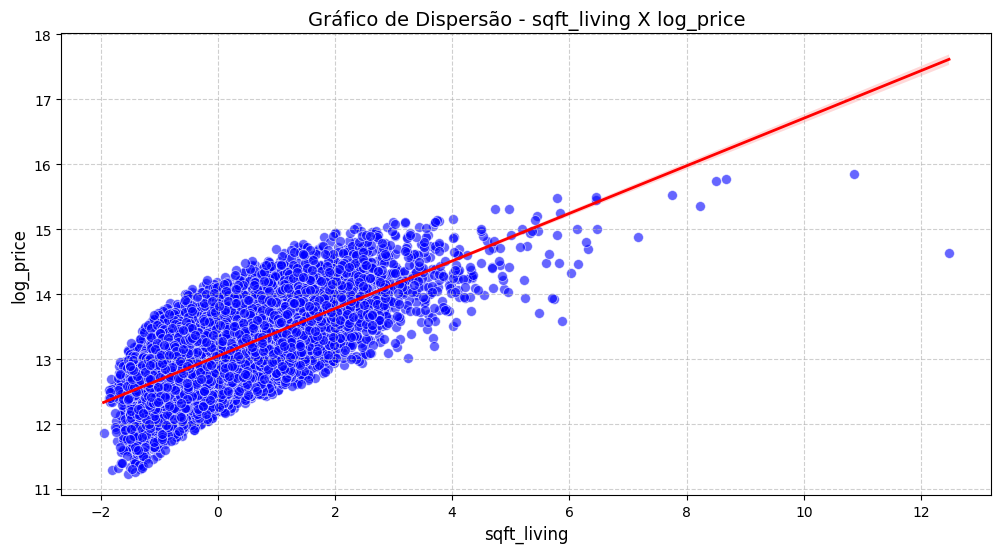

In [27]:
criar_grafico_dispersao(house_sales_data_01_normalizado, 'sqft_living', 'log_price', cor="blue", tamanho_ponto=50)

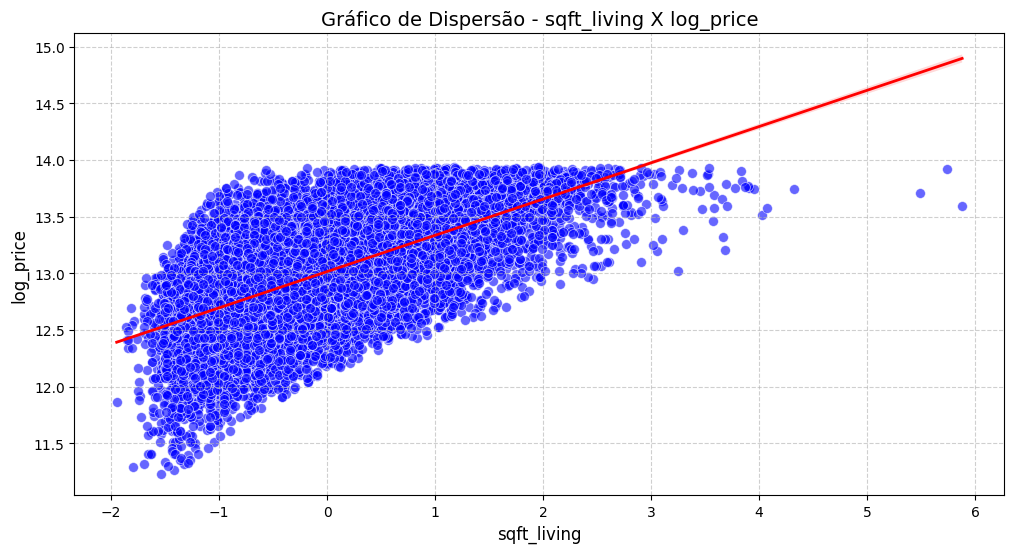

In [28]:
criar_grafico_dispersao(house_sales_data_01_normalizado_sem_outliers, 'sqft_living', 'log_price', cor="blue", tamanho_ponto=50)

---

O primeiro gráfico mostrou a relação entre `sqft_living` e `price` com **outliers significativos**, o que distorceu a regressão. No segundo gráfico, a remoção de outliers melhorou o ajuste da reta de regressão, tornando a relação mais estável. Já no terceiro gráfico, foi aplicada a transformação logarítmica (`log_price`), mas mantendo os outliers, o que ainda comprometeu o modelo, pois os valores extremos continuaram influenciando a inclinação da reta de regressão e geraram uma dispersão não homogênea. O quarto gráfico, que utilizou a transformação logarítmica (`log_price`) com remoção dos outliers, e assim reduziu a **heterocedasticidade**, tornando a relação mais linear e garantindo uma modelagem mais confiável.  
 

---

#### 4.4.2) Variável `bathrooms`

          bathrooms
count  21613.000000
mean       2.114757
std        0.770163
min        0.000000
25%        1.750000
50%        2.250000
75%        2.500000
max        8.000000
______________________________________________________________________________________________


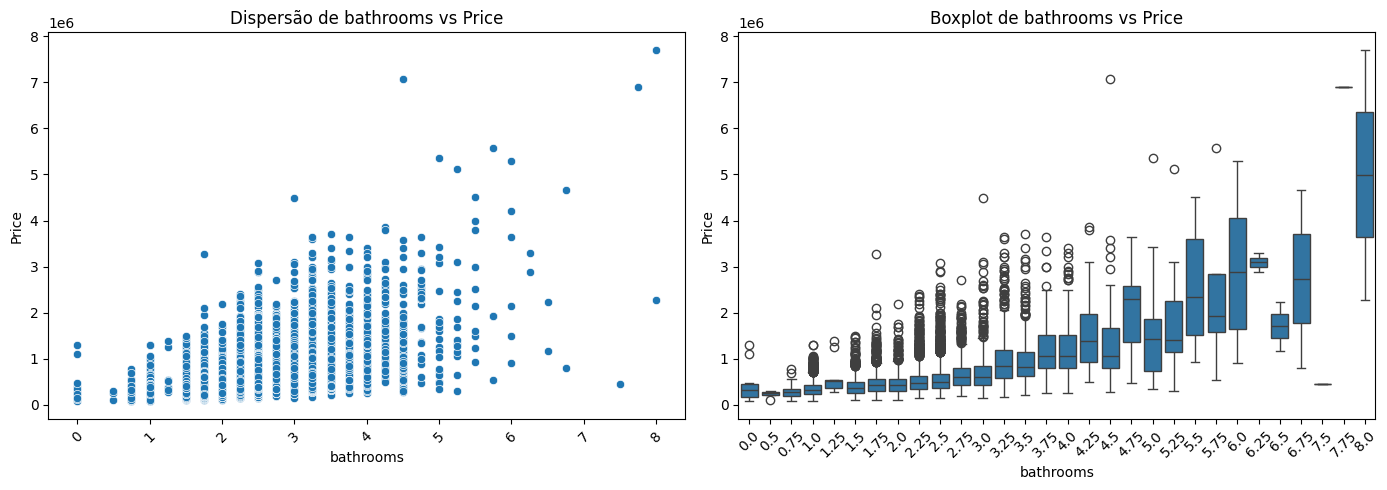

______________________________________________________________________________________________
Correlação de Pearson: 0.525 (p-valor: 0.000)
______________________________________________________________________________________________
bathrooms
2.50    5380
1.00    3852
1.75    3048
2.25    2047
2.00    1930
1.50    1446
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      72
4.75      23
5.00      21
5.25      13
0.00      10
5.50      10
1.25       9
6.00       6
0.50       4
5.75       4
6.75       2
8.00       2
6.50       2
6.25       2
7.75       1
7.50       1
Name: count, dtype: int64
______________________________________________________________________________________________
Resultado ANOVA: F=413.847, p=0.000
______________________________________________________________________________________________


In [29]:
analise_variavel_categorica(house_sales_data_01, 'bathrooms')

**Análise da Variável `bedrooms` para Regressão Linear**

- **Distribuição**: A maioria das casas possui **entre 1,5 e 2,5 banheiros**, com um máximo de **8 banheiros**, indicando alguns outliers.  
- **Correlação de Pearson**: `0.525` (**p-valor = 0.000**), indicando uma **correlação moderada** com o preço (`price`).  

- O **gráfico de dispersão** mostra um padrão positivo, mas com bastante dispersão, especialmente para casas com mais de 4 banheiros.  
- O **boxplot** sugere um aumento no preço médio conforme o número de banheiros cresce, mas também apresenta uma grande variação dentro de cada grupo, o que pode indicar que a relação não é puramente linear.  

- **ANOVA**: O resultado (`F = 413.847`, `p-valor = 0.000`) confirma que há diferenças estatisticamente significativas entre os grupos de `bathrooms`, sugerindo que essa variável pode ser relevante para prever `price`. 

---

#### 4.4.3) Variável `yr_built`

           yr_built
count  21613.000000
mean    1971.005136
std       29.373411
min     1900.000000
25%     1951.000000
50%     1975.000000
75%     1997.000000
max     2015.000000
______________________________________________________________________________________________


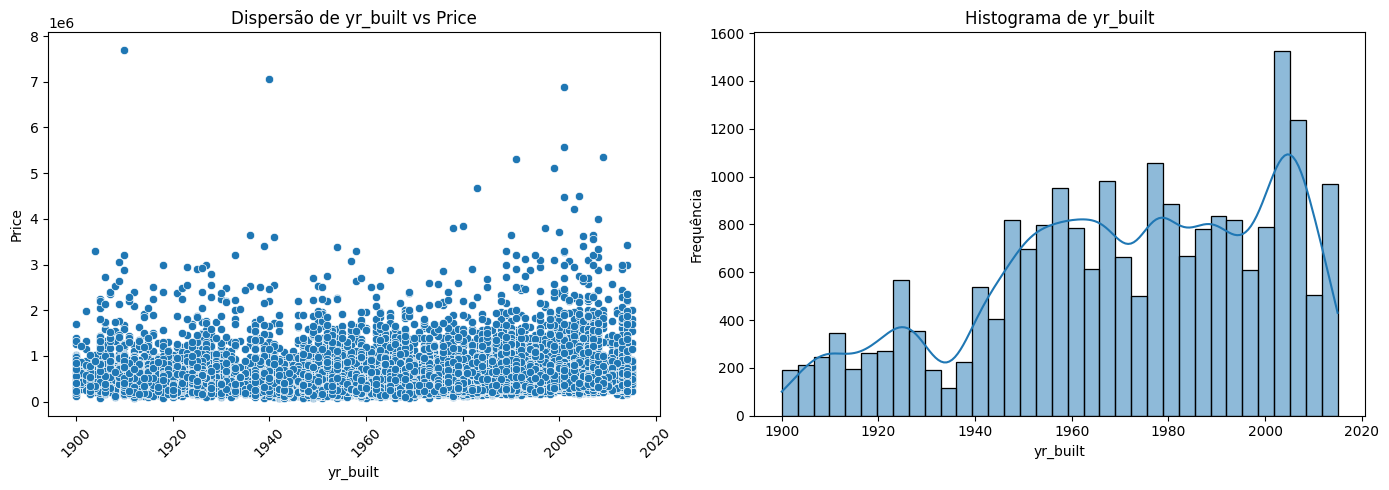

______________________________________________________________________________________________
Correlação de Pearson: 0.054 (p-valor: 0.000)
______________________________________________________________________________________________
______________________________________________________________________________________________


In [30]:
analise_variavel_continua(house_sales_data_01, 'yr_built')

**Análise da Variável `yr_built` para Regressão Linear**

- **Distribuição**: A maioria das casas foi construída entre **1950 e 2000**, com um crescimento acentuado nas construções após os anos 2000.  
- **Correlação de Pearson**: `0.054` (**p-valor = 0.000**), indicando uma **correlação muito fraca** entre `yr_built` e `price`, sugerindo que o ano de construção, isoladamente, tem pouco impacto direto no preço das casas.  

---


#### 4.4.4) Variável `zipcode`

            zipcode
count  21613.000000
mean   98077.939805
std       53.505026
min    98001.000000
25%    98033.000000
50%    98065.000000
75%    98118.000000
max    98199.000000
______________________________________________________________________________________________


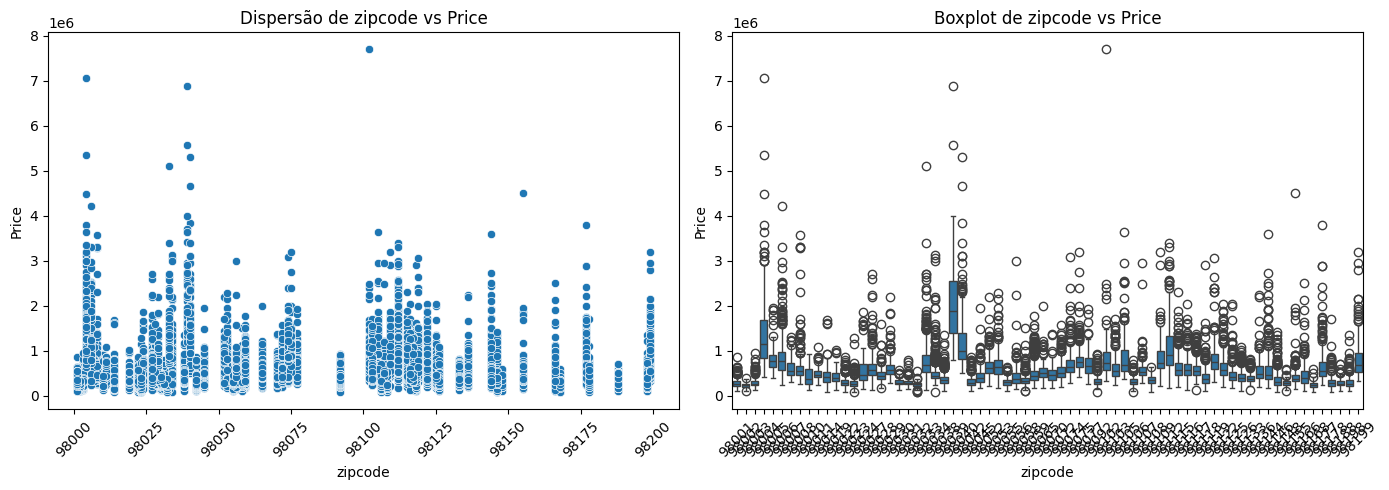

______________________________________________________________________________________________
Correlação de Pearson: -0.051 (p-valor: 0.000)
______________________________________________________________________________________________
zipcode
98103    602
98038    590
98115    583
98052    574
98117    553
        ... 
98102    105
98010    100
98024     81
98148     57
98039     50
Name: count, Length: 70, dtype: int64
______________________________________________________________________________________________
Resultado ANOVA: F=214.633, p=0.000
______________________________________________________________________________________________


In [31]:
analise_variavel_categorica(house_sales_data_01, 'zipcode')

**Análise da Variável `zipcode` para Regressão Linear**

- **Distribuição**: O conjunto de dados possui **70 zipcodes distintos**, indicando uma ampla variação geográfica nos preços das casas.  
- **Correlação de Pearson**: `-0.051` (**p-valor = 0.000**), indicando uma **correlação extremamente fraca e negativa** entre `zipcode` e `price`, sugerindo que o código postal, por si só, não tem uma relação linear forte com o preço.   

- O **gráfico de dispersão** mostra padrões agrupados por `zipcode`, mas sem uma relação clara e contínua com `price`.  
- O **boxplot** exibe variação de preços dentro de cada `zipcode`, indicando que a localização pode afetar o preço, mas essa influência pode estar melhor representada por outras variáveis, como `sqft_living`, `view` e `grade`.

O `zipcode` **não será utilizado no modelo**.

---


#### 4.4.5) Variável `yr_renovated`

       yr_renovated
count  21613.000000
mean      84.402258
std      401.679240
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max     2015.000000
______________________________________________________________________________________________


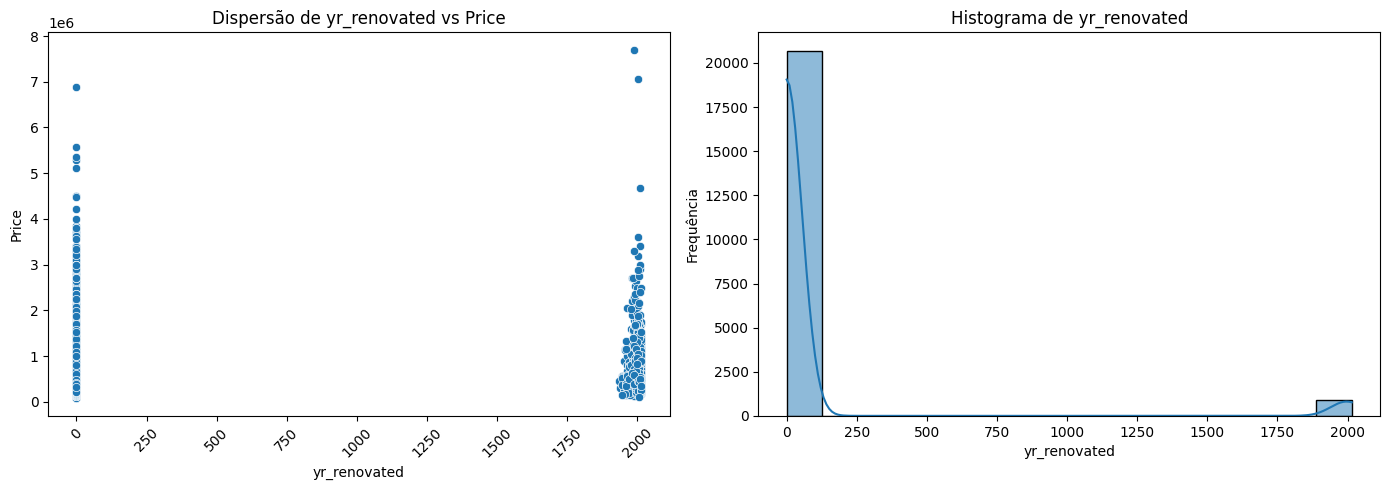

______________________________________________________________________________________________
Correlação de Pearson: 0.126 (p-valor: 0.000)
______________________________________________________________________________________________
______________________________________________________________________________________________


In [32]:
analise_variavel_continua(house_sales_data_01, 'yr_renovated')

**Análise da Variável `yr_renovated` para Regressão Linear**

- **Distribuição**: A maioria das casas **nunca foi renovada** (`yr_renovated = 0` em pelo menos 75% dos casos), com poucas apresentando valores de renovação maiores.
- **Correlação de Pearson**: `0.126` (p-valor `0.000`), indicando uma **correlação fraca, porém estatisticamente significativa**, com o preço.

A variável `yr_renovated` tem **baixo impacto linear no preço**, pois a correlação é fraca e a maioria das casas não foi renovada, **não será utilizada no modelo**.

---


#### 4.4.6) Variável `view`

               view
count  21613.000000
mean       0.234303
std        0.766318
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        4.000000
______________________________________________________________________________________________


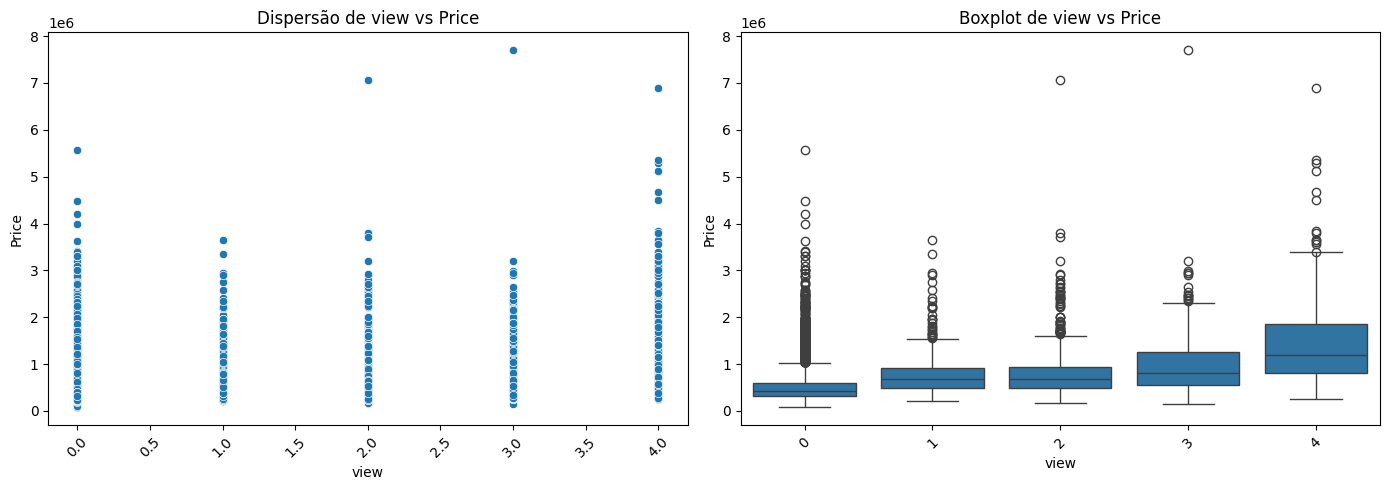

______________________________________________________________________________________________
Correlação de Pearson: 0.397 (p-valor: 0.000)
______________________________________________________________________________________________
view
0    19489
2      963
3      510
1      332
4      319
Name: count, dtype: int64
______________________________________________________________________________________________
Resultado ANOVA: F=1092.688, p=0.000
______________________________________________________________________________________________


In [33]:
analise_variavel_categorica(house_sales_data_01, 'view')

---

- **Distribuição**: A grande maioria das casas (**~90%**) não possui vista privilegiada (`view = 0`), enquanto apenas um pequeno percentual apresenta avaliações mais altas (`view = 1 a 4`).  
- **Correlação de Pearson**: `0.397` (**p-valor = 0.000**), indicando uma **correlação moderada positiva** entre `view` e `price`, sugerindo que casas com melhor vista tendem a ser mais caras.  

- O **gráfico de dispersão** mostra uma separação clara entre os grupos de `view`, com preços mais altos concentrados nas categorias superiores.  
- O **boxplot** confirma essa tendência, com **a mediana dos preços aumentando conforme `view` melhora**, embora ainda haja alta variabilidade dentro de cada grupo.  
- **ANOVA**: O resultado (`F = 1092.688`, `p-valor = 0.000`) confirma que **há uma diferença estatisticamente significativa** nos preços médios entre os diferentes níveis de `view`, reforçando seu impacto na precificação dos imóveis.  

A variável `view` apresenta **correlação moderada e estatisticamente significativa** com o preço das casas. Apesar da grande concentração de valores em `0`, os níveis superiores indicam um diferencial de preço relevante. 

---


## 5) Construção do modelo de regressão linear

### 5.1) Executando o modelo


Verificação de Multicolinearidade (VIF)
      Variável       VIF
0  sqft_living  1.787931
1     bedrooms  1.537119
2     yr_built  1.169563
3         view  1.061713

Indicadores do Modelo de Regressão Linear:
🔹 Mean Absolute Error (MAE): 123737.12
🔹 Mean Squared Error (MSE): 23945820648.87
🔹 Root Mean Squared Error (RMSE): 154744.37
🔹 R² Score: 0.4250
______________________________________________________________________________________________

Coeficientes do Modelo:
      Variável    Coeficiente
0  sqft_living  180386.019560
3         view   27371.151096
1     bedrooms  -22346.829073
2     yr_built  -35020.904185

Interceptação (constante): 498628.7436
______________________________________________________________________________________________


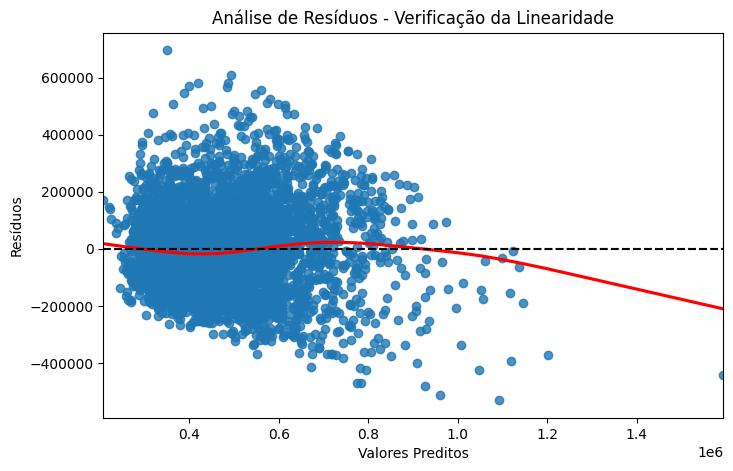

In [34]:
# Executa o modelo considerando as variáveis independentes normalizadas e SEM OUTLIERS
modelo = executar_regressao_linear(house_sales_data_01_normalizado_sem_outliers, ['sqft_living', 'bedrooms', 'yr_built', 'view'], 'price')


Verificação de Multicolinearidade (VIF)
      Variável       VIF
0  sqft_living  1.823606
1     bedrooms  1.520672
2     yr_built  1.144744
3         view  1.131246

Indicadores do Modelo de Regressão Linear:
🔹 Mean Absolute Error (MAE): 163957.44
🔹 Mean Squared Error (MSE): 65553337403.15
🔹 Root Mean Squared Error (RMSE): 256033.86
🔹 R² Score: 0.5664
______________________________________________________________________________________________

Coeficientes do Modelo:
      Variável    Coeficiente
0  sqft_living  285112.972644
3         view   64166.120843
1     bedrooms  -45930.650296
2     yr_built  -60490.192378

Interceptação (constante): 539817.9302
______________________________________________________________________________________________


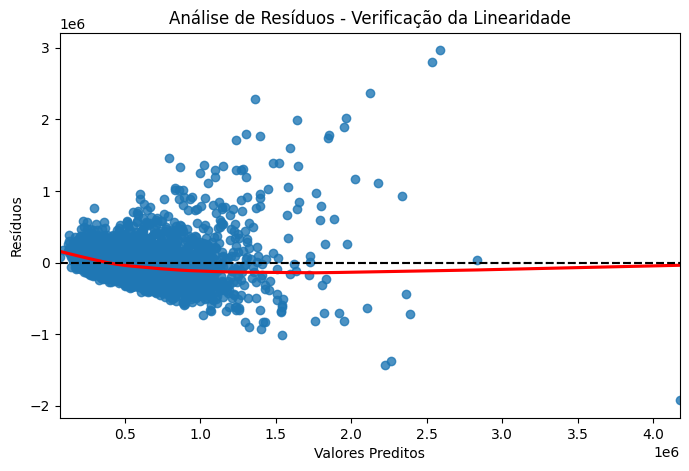

In [35]:
# Executa o modelo considerando as variáveis independentes normalizadas e COM OUTLIERS
modelo = executar_regressao_linear(house_sales_data_01_normalizado, ['sqft_living', 'bedrooms', 'yr_built', 'view'], 'price')

---

**Análise Comparativa dos Modelos de Regressão Linear**

Os dois modelos foram ajustados considerando as mesmas variáveis independentes (`sqft_living`, `bedrooms`, `yr_built`, `view`), porém um modelo foi treinado **sem outliers**, enquanto o outro **manteve os outliers** nos dados. Abaixo está uma comparação dos principais aspectos:

**1. Multicolinearidade (VIF)**
O VIF (Variance Inflation Factor) indica a multicolinearidade entre as variáveis preditoras. Em ambos os modelos, os valores de VIF são baixos, indicando ausência de multicolinearidade severa.

- **Sem Outliers**: Os VIFs variam entre **1.06 e 1.78**.
- **Com Outliers**: Os VIFs variam entre **1.13 e 1.82**.

A inclusão dos outliers **não afetou significativamente** a multicolinearidade.

**2. Qualidade do Ajuste (Métricas de Erro e R²)**

| Métrica | **Sem Outliers** | **Com Outliers** | Impacto |
|---------|----------------|----------------|---------|
| **MAE** (Erro Absoluto Médio) | 123737.12 | 163357.44 | Aumento (~32%) |
| **MSE** (Erro Quadrático Médio) | 23945820648.87 | 65553734894.15 | Aumento significativo |
| **RMSE** (Raiz do Erro Quadrático Médio) | 154744.37 | 256833.86 | Aumento significativo |
| **R² Score** | 0.4259 | 0.5664 | Melhor ajuste com outliers |

- O **modelo com outliers apresenta um R² maior** (0.5664 vs. 0.4259), indicando que ele consegue explicar uma **porcentagem maior da variabilidade dos preços**.
- No entanto, **os erros (MAE, MSE, RMSE) aumentaram substancialmente**, sugerindo que os outliers **influenciaram o ajuste do modelo**, tornando-o mais sensível a variações extremas.

**3. Coeficientes do Modelo**

| Variável | **Sem Outliers** | **Com Outliers** | Impacto |
|----------|----------------|----------------|---------|
| **sqft_living** | 188386.02 | 285112.97 | Aumento significativo |
| **view** | 27731.15 | 46166.12 | Aumento significativo |
| **bedrooms** | -22346.83 | -45930.66 | Aumento da penalização |
| **yr_built** | -35208.90 | -68409.19 | Aumento da penalização |
| **Interceptação** | 498628.74 | 539817.94 | Aumento |

- Os coeficientes aumentaram significativamente quando os outliers foram mantidos, indicando que o modelo **ajustou as variáveis de forma mais intensa para acomodar os valores extremos**.
- As variáveis `bedrooms` e `yr_built` tiveram **coeficientes negativos**, sugerindo que, nesses dados, mais quartos ou construções mais antigas podem estar associadas a preços menores.

**4. Análise dos Resíduos**
Os gráficos de resíduos indicam se o modelo respeita a suposição de linearidade e homocedasticidade.

**Sem Outliers**
- A dispersão dos resíduos parece **mais uniforme** ao longo dos valores preditos.
- A curva vermelha (tendência) está **mais estável**, sugerindo um ajuste mais consistente.
- Há **menos pontos extremos** com grandes desvios.

**Com Outliers**
- Os resíduos apresentam **maior dispersão e variação**, com valores extremamente altos ou baixos.
- A curva vermelha mostra uma **tendência não linear**, indicando que o modelo pode estar sofrendo influência dos outliers, desviando-se da suposição de linearidade.
- Há **mais pontos extremos**, sugerindo **heterocedasticidade** (variação desigual dos erros).

**Conclusões**

| Critério | **Sem Outliers** | **Com Outliers** | Melhor Opção? |
|----------|----------------|----------------|--------------|
| **Multicolinearidade** | Baixa | Baixa | **Empate** |
| **Erro do Modelo (MAE, MSE, RMSE)** | Menor | Maior | **Sem Outliers** |
| **Poder Explicativo (R²)** | Menor | Maior | **Com Outliers** |
| **Estabilidade dos Coeficientes** | Mais Estáveis | Mais Sensíveis | **Sem Outliers** |
| **Análise dos Resíduos** | Melhor Distribuição | Alta Dispersão | **Sem Outliers** |

- O **modelo sem outliers** apresenta **menores erros, coeficientes mais estáveis e resíduos mais distribuídos**, sugerindo que ele pode ser **mais confiável e generalizável**.
- O **modelo com outliers** possui um R² maior, mas **é mais sensível a extremos**, podendo superajustar os dados.


---


### 5.2) Ajustes no modelo

In [36]:
# Valida o modelo com várias variáveis independentes, considerando a utilização de pelos menos 4 variáveis independentes. 
# VARIÁVEIS NORMALIZADAS E SEM OUTLIERS
# Considera a regressão com o modelo normalizado, sem outliers.
# Como o processoamento é demorado, o resultado foi armazenado em arquivo para processamentos posteriores.

# independent_vars = ['bedrooms', 'bathrooms', 'sqft_living',
#        'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
#        'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
#        'lat', 'long', 'sqft_living15', 'sqft_lot15']
# dependent_var = ['price','log_price']

# results_df, best_model = evaluate_regression(house_sales_data_01_normalizado_sem_outliers, independent_vars, dependent_var)

# **Resultado do Processamento**

🔹 **Total de execuções esperadas:** 523944  

| Execuções Concluídas | Tempo Decorrido (s) |
|----------------------|--------------------|
| ✅ 5000 / 523944  | 31.93  |
| ✅ 10000 / 523944  | 64.63  |
| ✅ 15000 / 523944  | 99.09  |
| ✅ 20000 / 523944  | 133.49  |
| ✅ 25000 / 523944  | 167.94  |
| ✅ 30000 / 523944  | 202.15  |
| ✅ 35000 / 523944  | 239.35  |
| ✅ 40000 / 523944  | 278.42  |
| ✅ 45000 / 523944  | 321.36  |
| ✅ 50000 / 523944  | 370.53  |
| ✅ 55000 / 523944  | 408.08  |
| ✅ 60000 / 523944  | 447.78  |
| ✅ 65000 / 523944  | 488.98  |
| ✅ 70000 / 523944  | 532.53  |
| ✅ 75000 / 523944  | 574.33  |
| ✅ 80000 / 523944  | 617.75  |
| ✅ 85000 / 523944  | 665.08  |
| ✅ 90000 / 523944  | 708.70  |
| ✅ 95000 / 523944  | 751.19  |
| ✅ 100000 / 523944  | 794.46  |
| ✅ 150000 / 523944  | 1259.49  |
| ✅ 200000 / 523944  | 1794.03  |
| ✅ 250000 / 523944  | 2424.16  |
| ✅ 300000 / 523944  | 2980.08  |
| ✅ 350000 / 523944  | 3565.19  |
| ✅ 400000 / 523944  | 4198.71  |
| ✅ 450000 / 523944  | 4773.90  |
| ✅ 500000 / 523944  | 5536.30  |
| ✅ 520000 / 523944  | 5778.50  |
| ✅ 523944 / 523944  | 5835.10  |

🚀 **Processo finalizado!**  
⏳ **Tempo total:** 5835.88 segundos  


In [37]:
# results_df.to_csv(f'{diretorio}/house_sales_data_01_normalizado_sem_outliers_results.csv', index=False, encoding="utf-8")

In [38]:
# Considera que o processamento anterior já ocorreu
house_sales_data_01_normalizado_sem_outliers_results = pd.read_csv(f'{diretorio}/house_sales_data_01_normalizado_sem_outliers_results.csv', delimiter=',')

house_sales_data_01_normalizado_sem_outliers_results_best = house_sales_data_01_normalizado_sem_outliers_results.loc[house_sales_data_01_normalizado_sem_outliers_results.groupby('Variável Dependente')['RMSE'].idxmin()]
house_sales_data_01_normalizado_sem_outliers_results_best.head(1)

,Variável Dependente,Variáveis Independentes,MAE,MSE,RMSE,R² Score,Coeficientes
522319,log_price,"('bathrooms', 'sqft_living', 'sqft_lot', 'floo...",0.187272,0.057564,0.239926,0.700414,"{'bathrooms': np.float64(0.04885022888389863),..."


In [39]:
# Exibir toda a primeira linha da coluna Variáveis Independentes
print('Variáveis Independentes')
print(house_sales_data_01_normalizado_sem_outliers_results_best['Variáveis Independentes'].iloc[0])
print('')

# Exibir toda a primeira linha da coluna Coeficientes
print('Coeficientes')
print(house_sales_data_01_normalizado_sem_outliers_results_best['Coeficientes'].iloc[0])
print('')

# Exibir toda a primeira linha da coluna Coeficientes
# print('R² Score')
# print(house_sales_data_01_normalizado_sem_outliers_results_best['R2 Score'].iloc[0])

Variáveis Independentes
('bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'yr_built', 'yr_renovated', 'lat', 'sqft_living15', 'sqft_lot15')

Coeficientes
{'bathrooms': np.float64(0.04885022888389863), 'sqft_living': np.float64(0.1264829322971912), 'sqft_lot': np.float64(0.021252827684950355), 'floors': np.float64(0.04248586548810966), 'waterfront': np.float64(0.025971792797526396), 'view': np.float64(0.04121773286063239), 'condition': np.float64(0.04350440710749343), 'grade': np.float64(0.17567570925781872), 'sqft_above': np.float64(-0.021907222004672128), 'yr_built': np.float64(-0.08872141154484489), 'yr_renovated': np.float64(0.011228095963768465), 'lat': np.float64(0.1852912669839634), 'sqft_living15': np.float64(0.07060874686621282), 'sqft_lot15': np.float64(-0.0019179779634322278)}




Verificação de Multicolinearidade (VIF)
         Variável       VIF
0       bathrooms  2.946550
1     sqft_living  6.550388
2        sqft_lot  2.038376
3          floors  2.014558
4      waterfront  1.107850
5            view  1.220287
6       condition  1.219690
7           grade  2.766997
8      sqft_above  5.897371
9        yr_built  2.228779
10   yr_renovated  1.129252
11            lat  1.124477
12  sqft_living15  2.717273
13     sqft_lot15  2.065709

Indicadores do Modelo de Regressão Linear:
🔹 Mean Absolute Error (MAE): 0.19
🔹 Mean Squared Error (MSE): 0.06
🔹 Root Mean Squared Error (RMSE): 0.24
🔹 R² Score: 0.7004
______________________________________________________________________________________________

Coeficientes do Modelo:
         Variável  Coeficiente
11            lat     0.185291
7           grade     0.175676
1     sqft_living     0.126483
12  sqft_living15     0.070609
0       bathrooms     0.048850
6       condition     0.043504
3          floors     0.042486
5 

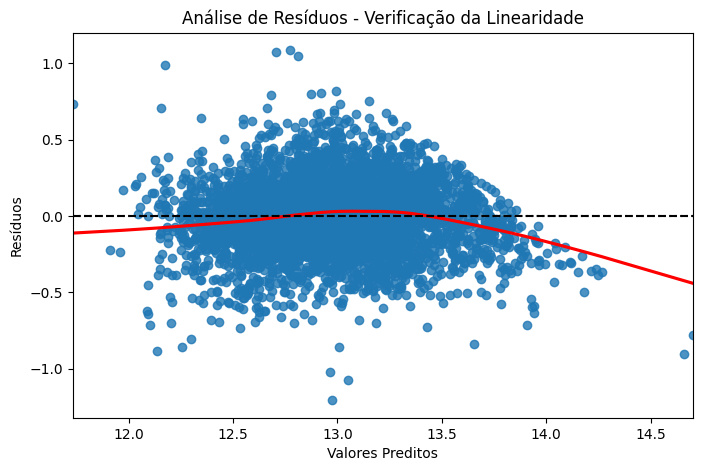

In [40]:
modelo = executar_regressao_linear(
    house_sales_data_01_normalizado_sem_outliers,
    ['bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 
     'condition', 'grade', 'sqft_above', 'yr_built', 'yr_renovated', 'lat', 
     'sqft_living15', 'sqft_lot15'],  
    'log_price'
)


Verificação de Multicolinearidade (VIF)
         Variável       VIF
0       bathrooms  3.218954
1     sqft_living  7.945102
2        sqft_lot  2.089519
3          floors  1.953928
4      waterfront  1.200897
5            view  1.402257
6       condition  1.227605
7           grade  3.270662
8      sqft_above  6.670231
9        yr_built  2.127738
10   yr_renovated  1.145280
11            lat  1.120047
12  sqft_living15  2.819775
13     sqft_lot15  2.115408

Indicadores do Modelo de Regressão Linear:
🔹 Mean Absolute Error (MAE): 0.20
🔹 Mean Squared Error (MSE): 0.07
🔹 Root Mean Squared Error (RMSE): 0.26
🔹 R² Score: 0.7670
______________________________________________________________________________________________

Coeficientes do Modelo:
         Variável  Coeficiente
11            lat     0.188613
7           grade     0.188165
1     sqft_living     0.132472
12  sqft_living15     0.070252
0       bathrooms     0.054915
5            view     0.045970
6       condition     0.042282
3 

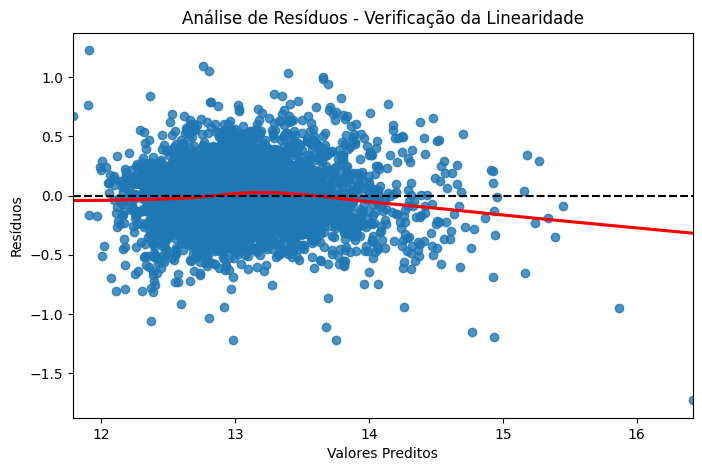

In [41]:
modelo = executar_regressao_linear(
    house_sales_data_01_normalizado,
    ['bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 
     'condition', 'grade', 'sqft_above', 'yr_built', 'yr_renovated', 'lat', 
     'sqft_living15', 'sqft_lot15'],  
    'log_price'
)

---

**Análise Comparativa dos Modelos de Regressão Linear**

Os dois modelos foram ajustados utilizando múltiplas variáveis preditoras, e abaixo está uma análise comparativa dos principais indicadores e comportamentos dos resíduos.

**1. Multicolinearidade (VIF)**

O VIF (Variance Inflation Factor) indica a multicolinearidade entre as variáveis preditoras. Em ambos os modelos, os valores de VIF são relativamente baixos, sugerindo que a colinearidade entre as variáveis não é um problema significativo.

**Comparação do VIF**
- **Modelo 1:**
  - `sqft_living`: **6.55**
  - `sqft_lot15`: **2.07**
  - `bathrooms`: **2.95**
  - `floors`: **2.01**
  - `view`: **1.22**
  - `yr_renovated`: **1.13**
  - `grade`: **2.77**
  - `sqft_above`: **5.90**
  - `yr_built`: **2.23**
  - `lat`: **1.12**
  - Outras variáveis possuem VIF abaixo de **3**.

- **Modelo 2:**
  - `sqft_living`: **7.95** (ligeiro aumento)
  - `sqft_lot15`: **2.12** (redução em relação ao primeiro modelo)
  - `bathrooms`: **3.22** (ligeiro aumento)
  - `floors`: **1.95**
  - `view`: **1.40**
  - `yr_renovated`: **1.15**
  - `grade`: **3.27**
  - `sqft_above`: **6.67**
  - `yr_built`: **2.13**
  - `lat`: **1.12**
  - Outras variáveis mantêm valores similares.

**Impacto da Multicolinearidade**
- O **Modelo 2 apresenta um VIF ligeiramente maior para `sqft_living` e `grade`**, mas ainda dentro de uma faixa aceitável para regressão múltipla.
- A inclusão de mais dados pode ter causado um pequeno aumento da correlação entre algumas variáveis.

**2. Qualidade do Ajuste (Métricas de Erro e R²)**

| Métrica | **Modelo 1** | **Modelo 2** | Impacto |
|---------|-------------|-------------|---------|
| **MAE (Erro Absoluto Médio)** | 0.19 | 0.20 | Aumento pequeno |
| **MSE (Erro Quadrático Médio)** | 0.06 | 0.07 | Aumento leve |
| **RMSE (Raiz do Erro Quadrático Médio)** | 0.24 | 0.26 | Aumento leve |
| **R² Score** | 0.7004 | 0.7670 | Aumento no Modelo 2 |

- O **Modelo 2 apresenta um desempenho levemente melhor** em termos de explicabilidade dos dados.
- O **R² do Modelo 2 é maior** (**0.7670 vs. 0.7004**), indicando que ele explica uma porcentagem maior da variabilidade dos dados.

**3. Coeficientes do Modelo**

Os coeficientes indicam a influência de cada variável na predição do modelo.

| Variável | **Modelo 1** | **Modelo 2** | Impacto |
|----------|-------------|-------------|---------|
| **lat** | 0.185291 | 0.188613 | Pequeno aumento |
| **grade** | 0.175676 | 0.188165 | Aumento |
| **sqft_living** | 0.126483 | 0.132472 | Aumento |
| **bathrooms** | 0.048850 | 0.054915 | Pequeno aumento |
| **yr_built** | -0.088721 | -0.099222 | Redução mais negativa |
| **sqft_lot15** | -0.001918 | -0.005109 | Pequena mudança |
| **floors** | 0.042486 | 0.038139 | Pequena redução |
| **view** | 0.041218 | 0.045970 | Pequeno aumento |
| **condition** | 0.043504 | 0.042282 | Pequena variação |
| **waterfront** | 0.025972 | 0.033346 | Aumento |
| **yr_renovated** | 0.011228 | 0.015087 | Pequeno aumento |
| **sqft_above** | -0.021907 | -0.012472 | Pequena mudança |

**4. Análise dos Resíduos**

**Modelo 1 (Resíduos)**

- Resíduos estão **mais concentrados entre -0.5 e 0.5**.
- Há **leve curvatura** na linha de tendência (vermelha), mas não é muito acentuada.
- Indica um ajuste razoavelmente estável.

**Modelo 2 (Resíduos)**
- Maior dispersão dos resíduos, com **valores negativos chegando a -1.5**.
- A curvatura da linha vermelha **parece indicar alguma não linearidade**, podendo sugerir que o modelo não capturou todas as relações dos dados.

**Conclusão Geral**

| Critério | **Modelo 1** | **Modelo 2** | Melhor Opção? |
|----------|-------------|-------------|--------------|
| **Multicolinearidade (VIF)** | Baixa | Ligeiramente Maior | **Modelo 1** |
| **Erro do Modelo (MAE, MSE, RMSE)** | Menor | Maior | **Modelo 1** |
| **Poder Explicativo (R²)** | Menor | Maior | **Modelo 2** |
| **Coeficientes Estáveis** | Mais Consistentes | Mais Sensíveis | **Modelo 1** |
| **Análise dos Resíduos** | Melhor Distribuição | Maior Dispersão | **Modelo 1** |

O **Modelo 2 possui um melhor poder explicativo**, mas o **Modelo 1 tem menor erro e maior estabilidade**. 

---

## 6) Tomada de decisão

---

**Aplicação no Contexto de Negócios**

O modelo de regressão linear, sem outliers, utilizando as seguintes 14 variáveis preditoras - `bathrooms`, `sqft_living`, `sqft_lot`, `floors`, `waterfront`, `view`, `condition`, `grade`, `sqft_above`, `yr_built`, `yr_renovated`, `lat`, `sqft_living15`, `sqft_lot15`-  foi escolhido como a melhor opção devido ao seu **menor erro e maior estabilidade**, garantindo previsões mais confiáveis e consistentes. Embora o modelo com as mesmas variáveis preditoras, mas com os outliers, tenha um R² ligeiramente maior, a dispersão dos resíduos e a possível não linearidade indicam que ele pode não capturar corretamente todas as relações dos dados. 

O modelo escolhido apresentou em relação aos demais:
- **Menores valores de erro absoluto médio (MAE) e erro quadrático médio (MSE)**, indicando maior precisão.
- **Coeficientes mais estáveis**, o que reduz a sensibilidade a variações extremas nos dados.
- **Resíduos mais homogêneos**, sugerindo um ajuste mais confiável e menos sujeito a desvios extremos.

Portanto, para aplicações práticas, especialmente em ambientes empresariais, esse modelo oferece maior confiabilidade para tomada de decisões estratégicas.

Os coeficientes do modelo indicam a influência de diferentes variáveis sobre o preço de venda de um imóvel. Isso pode ser aplicado em diversas estratégias de negócios, como:

**Precificação Inteligente de Imóveis**
- O coeficiente de `sqft_living` (**0.126483**) mostra que um aumento na metragem quadrada da área útil do imóvel está associado a um aumento no preço final.
- Empresas do setor imobiliário podem usar esse dado para **ajustar os preços de venda e aluguel** com base nas características do imóvel, garantindo maior competitividade no mercado.
- Plataformas de precificação automatizada podem ser desenvolvidas para recomendar valores justos com base na metragem, localização e outras características relevantes.

**Estratégia de Investimentos Imobiliários**
- O coeficiente de `grade` (**0.175676**) sugere que imóveis com melhor qualidade de acabamento e materiais tendem a ter preços mais altos.
- Investidores podem **priorizar reformas e melhorias específicas**, como acabamentos premium, para maximizar a valorização dos imóveis antes da revenda.
- Incorporadoras podem definir planos de construção diferenciados para atender demandas de alto padrão, garantindo retorno sobre investimento (ROI) mais alto.

**Expansão e Desenvolvimento Urbano**
- O coeficiente de `lat` (**0.185291**) indica que a localização impacta significativamente no preço dos imóveis.
- Incorporadoras podem usar essa informação para **selecionar áreas estratégicas para novos empreendimentos**, focando em regiões que apresentam maior valorização imobiliária.
- Prefeituras e órgãos governamentais podem usar os dados para planejamento urbano, garantindo a criação de infraestrutura em locais que apresentam maior potencial de crescimento imobiliário.

**Planejamento de Crédito Imobiliário**
- A variável `yr_built` (**-0.088721**) sugere que imóveis mais antigos tendem a ter preços menores.
- Já a variável `yr_renovated` (**0.011228**) indica que reformas podem agregar valor ao imóvel.
- Bancos e instituições financeiras podem usar esses dados para **estruturar linhas de crédito diferenciadas**, oferecendo taxas mais atrativas para imóveis antigos que passaram por reformas ou que estejam localizados em áreas de valorização.
- Seguradoras podem utilizar essas informações para ajustar políticas de precificação de seguros imobiliários, considerando o impacto do tempo de construção e das renovações no valor total do imóvel.

**Melhoria nas Estratégias de Marketing Imobiliário**
- Com base nos coeficientes do modelo, campanhas de marketing podem ser mais direcionadas, destacando atributos que realmente influenciam o preço.
- Anunciantes podem criar anúncios personalizados, enfatizando aspectos valorizados pelo mercado, como metragem, localização e qualidade de acabamento.
- Portais imobiliários podem implementar sistemas de recomendação de imóveis baseados em variáveis de maior impacto, melhorando a experiência dos compradores.

A utilização do modelo proposto permite uma **tomada de decisão baseada em dados concretos**, possibilitando estratégias eficazes para precificação, investimentos e desenvolvimento imobiliário.


---